# **Model Training**

Importing Basic Libraries and setting input stream for training and testing data

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Dense, Lambda, Flatten
from keras.layers import Dropout
from keras.models import Model
#From Keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

#Re-size all the images
IMAGE_SIZE = [224,224]

train_path = '/content/drive/My Drive/Final Segmented Dataset/Train'
test_path = '/content/drive/My Drive/Final Segmented Dataset/Test'

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 2010 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [6]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
import vis
get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline

Adding Preprocessing layer to the front of VGG

In [7]:
IMAGE_SIZE = [224, 224]

vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 7s 0us/step


In [8]:
for layer in vgg.layers[:-7]:
      layer.trainable = False
      
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(100, activation = 'relu')(x)
x = Dropout(0.35)(x)
x = Dense(100, activation = 'relu')(x)
x = Dropout(0.35)(x)
x = Dense(100, activation = 'relu')(x)
x = Dropout(0.35)(x)
prediction = Dense(1, activation='sigmoid')(x)
#prediction = Dense(2, activation='softmax')(x)

In [9]:
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return float(lr * tf.math.exp(-0.1))
from keras import callbacks

callback = [callbacks.EarlyStopping(monitor='loss', patience=5), callbacks.LearningRateScheduler(scheduler, verbose=0)]

In [10]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
#model.summary()

In [11]:
model.compile(
  loss='binary_crossentropy', 
  optimizer='adam',
  metrics=['accuracy']
)
#loss='categorical_crossentropy',

In [12]:
history = model.fit_generator(training_set,
                         steps_per_epoch = len(training_set),
                         epochs = 50, callbacks = callback,
                         validation_data = test_set,
                         validation_steps = len(test_set))
len(history.history['loss'])  # Only 4 epochs are run.

Epoch 1/50
 9/63 [===>..........................] - ETA: 14:05 - loss: 0.8919 - accuracy: 0.4539

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 46 could not be retrieved. It could be because a worker has died.
  UserWarning)


63/63 [==============================] - 1094s 17s/step - loss: 0.7338 - accuracy: 0.4935 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 38s 597ms/step - loss: 0.7013 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 38s 601ms/step - loss: 0.6934 - accuracy: 0.4846 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
63/63 [==============================] - 38s 602ms/step - loss: 0.6934 - accuracy: 0.4905 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/50
63/63 [==============================] - 38s 602ms/step - loss: 0.6935 - accuracy: 0.4881 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/50
63/63 [==============================] - 38s 604ms/step - loss: 0.6934 - accuracy: 0.4975 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 7/50
63/63 [==============================] - 38s 604ms/step - loss: 0.6935 - accuracy: 0.4856 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 8/50

14

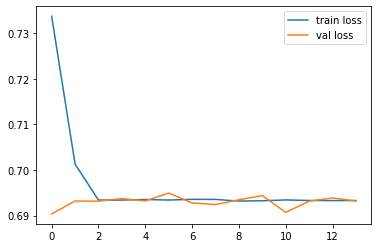

<Figure size 432x288 with 0 Axes>

In [13]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

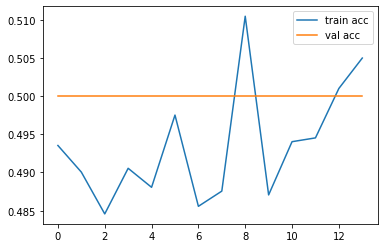

<Figure size 432x288 with 0 Axes>

In [14]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [15]:
import tensorflow as tf
from keras.models import load_model
model.save('/content/drive/My Drive/VGG19AS7.h5')

In [16]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np

img_path = '/content/drive/My Drive/Final Segmented Dataset/Validation/COVID Positive/X(977).jpg'
img = image.load_img(img_path, target_size=(224, 224))  #change to 224 , 224 , 3 if doesn't work
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

preds = model.predict(img_data)

# decode the results into a list of tuples (class, description, probability)
print('Predicted:', preds )   #decode_predictions(preds)

Predicted: [[0.49981105]]


In [17]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np

img_path = '/content/drive/My Drive/Final Segmented Dataset/Validation/COVID Negative/X(377).png'
img = image.load_img(img_path, target_size=(224, 224))  #change to 224 , 224 , 3 if doesn't work
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

preds = model.predict(img_data)

# decode the results into a list of tuples (class, description, probability)
print('Predicted:', preds )   #decode_predictions(preds)

Predicted: [[0.49981105]]


In [18]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np

img_path = '/content/drive/My Drive/Sample blacked out/CN.png'
img = image.load_img(img_path, target_size=(224, 224))  #change to 224 , 224 , 3 if doesn't work
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

preds = model.predict(img_data)

# decode the results into a list of tuples (class, description, probability)
print('Predicted:', preds )   #decode_predictions(preds)

Predicted: [[0.49981105]]


In [19]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np

img_path = '/content/drive/My Drive/Sample blacked out/CP1.jpg'
img = image.load_img(img_path, target_size=(224, 224))  #change to 224 , 224 , 3 if doesn't work
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

preds = model.predict(img_data)

# decode the results into a list of tuples (class, description, probability)
print('Predicted:', preds )   #decode_predictions(preds)

Predicted: [[0.49981105]]


In [ ]:
END